In [1]:
import sys
sys.path.append("./src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque

from Features import FeatureEngineer
from Environment import TradingEnvironment , random_policy

from tqdm import tqdm


In [5]:
gaz = pd.read_csv('data/Dutch TTF Natural Gas Futures - Données Historiques (1).csv')
fe_gaz = FeatureEngineer(gaz)
fe_gaz.apply_preprocessing()
gaz_df = fe_gaz.df
gaz_df

c:\Users\alexa\Documents\Visual Studio Code\Reinforcement-Learning-Project\./src\Features.py:34: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.df['Date']=pd.to_datetime(self.df['Date'])


,Date,Dernier,Ouv.,Plus Haut,Plus Bas,Vol.,Variation %,rsi,macd,ema20,ema50
1567,1514937600000000000,19.325,19.325,19.325,19.325,210.0,0.0003,0.340145,0.427470,0.062645,0.070533
1566,1515024000000000000,19.200,19.200,19.200,19.200,210.0,-0.0065,0.322674,0.427887,0.062343,0.070431
1565,1515110400000000000,18.915,18.915,18.915,18.915,210.0,-0.0148,0.284096,0.427832,0.061958,0.070277
1564,1515369600000000000,19.050,19.050,19.050,19.050,210.0,0.0071,0.313652,0.428520,0.061663,0.070156
1563,1515456000000000000,19.435,19.435,19.435,19.435,210.0,0.0202,0.392683,0.430260,0.061547,0.070114
...,...,...,...,...,...,...,...,...,...,...,...
4,1710115200000000000,24.930,25.970,26.465,24.760,450.0,-0.0553,0.363249,0.448066,0.086980,0.112738
3,1710201600000000000,24.775,25.010,25.010,24.355,300.0,-0.0062,0.354487,0.444207,0.086545,0.112058
2,1710288000000000000,24.905,25.100,25.425,24.555,240.0,0.0052,0.364842,0.441884,0.086202,0.111430
1,1710374400000000000,26.050,24.675,26.600,24.675,510.0,0.0460,0.450758,0.443094,0.086341,0.111047


# Environment

In [3]:
env = TradingEnvironment(data)

# env.observation_space.shape[0]
# env.action_space.n

# env.index_loc
# env.index_step
# env.index_loc + env.index_step

In [4]:
backtest_history = env.run_backtest(random_policy)

history_df = pd.DataFrame(backtest_history)
history_df

,balance,price,position,action,new_balance,new_price,new_position,reward,done
0,10000.000,22.380,0,0,10000.000,22.355,0,0.000,False
1,10000.000,22.355,0,1,9977.645,21.750,1,-0.605,False
2,9977.645,21.750,1,-1,9999.395,22.140,0,0.000,False
3,9999.395,22.140,0,0,9999.395,21.695,0,0.000,False
4,9999.395,21.695,0,0,9999.395,21.500,0,0.000,False
...,...,...,...,...,...,...,...,...,...
355,9603.720,16.120,21,1,9587.600,15.940,22,-3.960,False
356,9587.600,15.940,22,0,9587.600,15.845,22,-2.090,False
357,9587.600,15.845,22,1,9571.755,15.545,23,-6.900,False
358,9571.755,15.545,23,1,9556.210,15.450,24,-2.280,False


In [5]:
def visualize(prices, actions):
    buy_signals = []
    sell_signals = []

    for i in range(len(prices)):
        if actions[i] == 1:
            buy_signals.append(prices[i])
            sell_signals.append(None)
        elif actions[i] == -1:
            buy_signals.append(None)
            sell_signals.append(prices[i])
        else:
            buy_signals.append(None)
            sell_signals.append(None)

    plt.figure(figsize=(10, 6))
    plt.plot(prices, color='blue', label='Price')
    plt.scatter(range(len(prices)), buy_signals, color='green', label='Buy Signal', zorder=5)
    plt.scatter(range(len(prices)), sell_signals, color='red', label='Sell Signal', zorder=5)
    plt.title('Price with Buy/Sell Signals')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

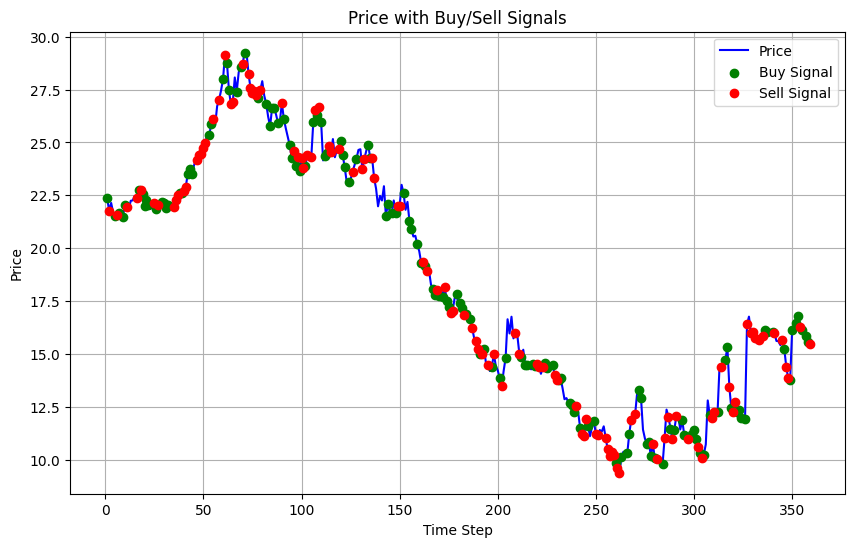

In [6]:
visualize(history_df['price'], history_df['action'])

# ReplayMemory

In [7]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.memory)
    

# DQN

In [8]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.softmax(self.fc3(x))
        x = self.fc3(x)
        return x

# Params

In [9]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
LR = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instanciation

In [10]:
num_observations = env.observation_space.shape[0]
num_actions = env.action_space.n

state = env.reset()

policy_net = DQN(num_observations, num_actions).to(device)
target_net = DQN(num_observations, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
replay_memory = ReplayMemory(10000)

# Greedy action

In [11]:
def epsilon_greedy_action(state, index_step):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1.0 * index_step / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
            # torch.Size([1, 1])
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        # torch.Size([1, 1])

# Train

In [12]:
def train_dqn(num_episodes):

    policy_net.train()
    history = []

    for episode in tqdm(range(num_episodes)):

        state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(0)
        # torch.Size([1, 3])

        for t in range(env.max_steps):

            action = epsilon_greedy_action(state, t) # torch.Size([1, 1])
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) # torch.Size([1, 3])
            reward = torch.tensor([reward], device=device)

            replay_memory.push(state, action, reward, next_state, done)

            state = next_state

            if len(replay_memory) > BATCH_SIZE:

                states, actions, rewards, next_states, dones = replay_memory.sample(BATCH_SIZE)

                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.long)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                states = states.squeeze(1) 
                # torch.Size([batch_size, num_actions])
                next_states = states.squeeze(1)
                # torch.Size([batch_size, num_actions])
                actions = actions.unsqueeze(1)
                # torch.Size([batch_size, 1])

                state_action_values = policy_net(states).gather(1, actions)
                # torch.Size([batch_size, 1])
                next_state_values = target_net(next_states).max(1)[0].detach()
                # torch.Size([batch_size, num_actions])
                expected_state_action_values = rewards + (1 - dones) * GAMMA * next_state_values

                criterion = nn.SmoothL1Loss()
                loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break
        
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        
        history.append(env.info)

        # print(f"Episode: {episode+1}, End Reward: {balance + price*pos}")

    return history
    
# Train the DQN
train_history = train_dqn(num_episodes=100)

100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


In [13]:
train_df = pd.DataFrame(train_history)
train_df.reward.mean()

0.6951399999998802

# Eval 

In [22]:
def eval_dqn(num_episodes):

    policy_net.eval()
    history = dict()

    for episode in tqdm(range(num_episodes)):

        state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(0)

        episode_history = []

        for _ in range(env.max_steps):

            action = policy_net(state).max(1).indices.view(1, 1)
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) # torch.Size([1, 3])
            reward = torch.tensor([reward], device=device)

            state = next_state

            episode_history.append(env.info)

            if done:
                break            
                
        history[episode+1] = episode_history

    return history
    
# Train the DQN
eval_history = eval_dqn(num_episodes=1000)

100%|██████████| 1000/1000 [01:24<00:00, 11.83it/s]


In [23]:
np.mean([v[-1]["reward"] for v in eval_history.values()])    

-7.624177999999937

(array([  1.,   1.,   1.,  13.,  64., 865.,  39.,   9.,   4.,   3.]),
 array([-4107.25, -3360.38, -2613.51, -1866.64, -1119.77,  -372.9 ,
          373.97,  1120.84,  1867.71,  2614.58,  3361.45]),
 <BarContainer object of 10 artists>)

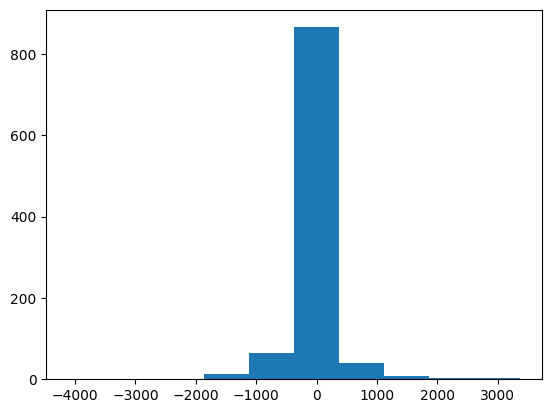

In [24]:
plt.hist([v[-1]["reward"] for v in eval_history.values()])

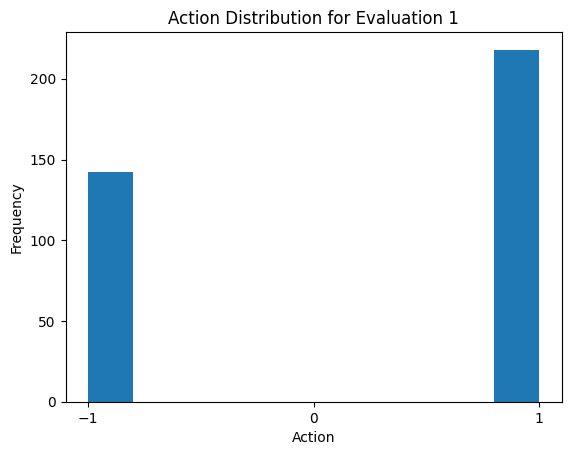

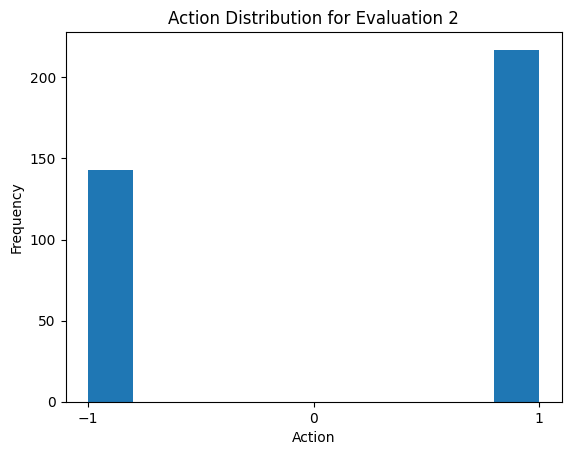

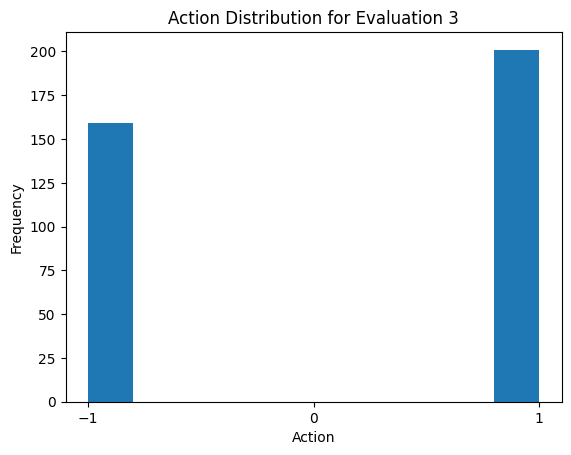

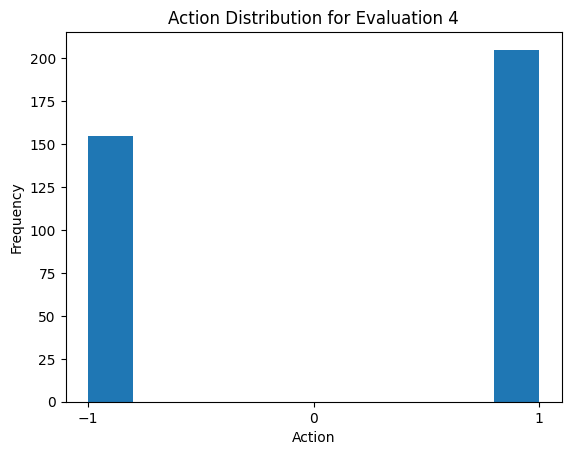

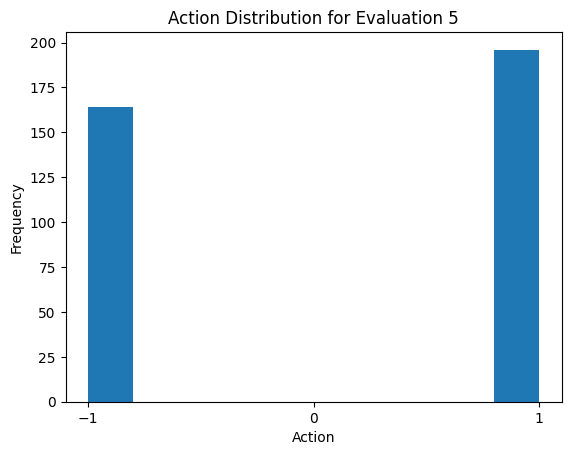

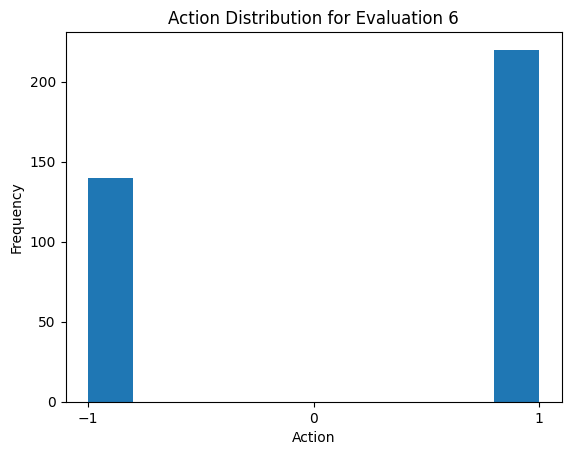

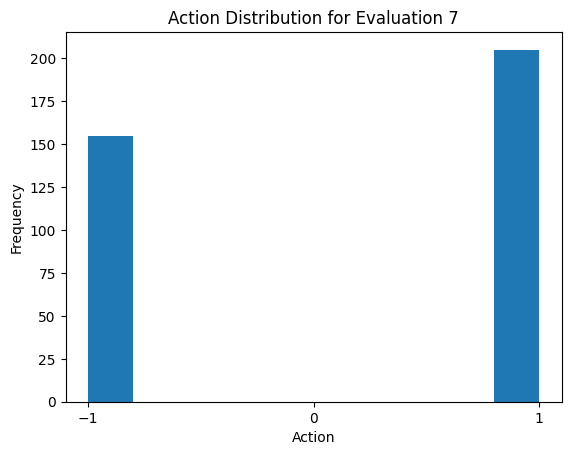

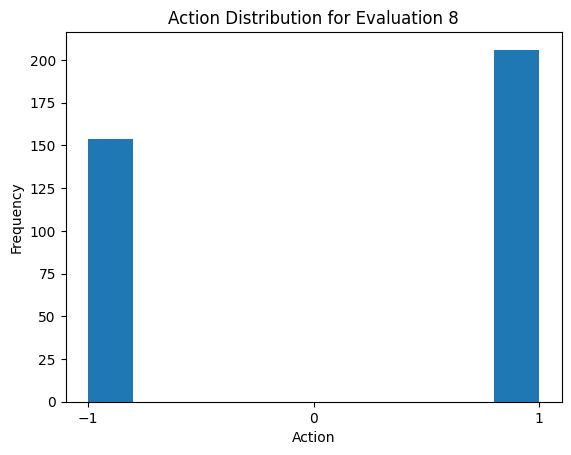

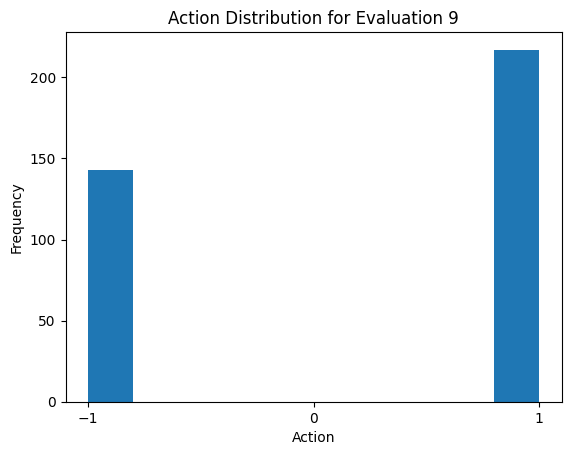

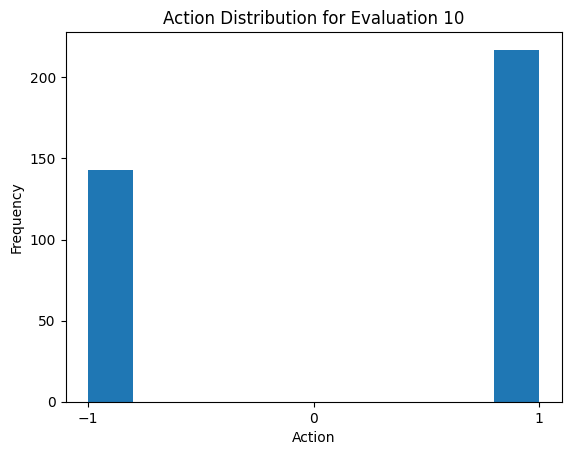

In [16]:
for k in eval_history.keys():
    eval_df = pd.DataFrame(eval_history[k])
    plt.hist(eval_df.action)
    plt.xticks([-1, 0, 1])  # Set the x-axis ticks to [1, 2, 3]
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.title(f'Action Distribution for Evaluation {k}')
    plt.show()

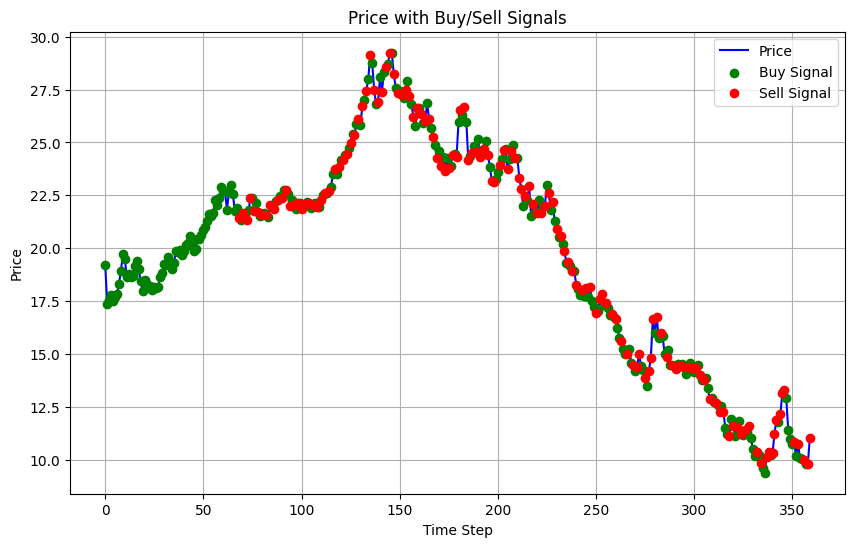

<Axes: >

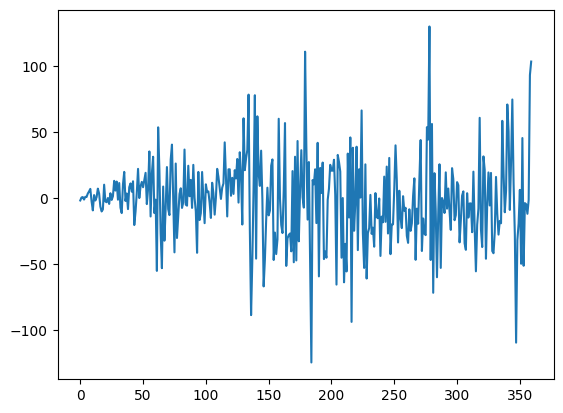

In [17]:
k = 1

eval_df = pd.DataFrame(eval_history[k])
visualize(eval_df.price, eval_df.action)
eval_df.reward.plot()

In [ ]:
df.reward

In [ ]:
history_1_df = pd.DataFrame(history[0])
history_1_df

In [ ]:
history_1_df = pd.DataFrame(history[1])
history_1_df.price.plot()

In [ ]:
history_1_df.reward.plot()
(history_1_df.reward - 10000).plot()


In [ ]:
# series = history_1_df.reward - 10000
series_2 = history_1_df.price

# plt.plot(series)
plt.plot(history_1_df.price)
plt.plot(history_1_df.reward)